# Fine-tuning for root inference

In [1]:
import os
import sys
import numpy as np
import torch

sys.path.append('../../modules/')

from logger_tree_language import get_logger
from pytorch_utilities import load_checkpoint
from models import replace_decoder_with_classification_head, freeze_encoder_weights
from training import train_model
from model_evaluation_tree_language import compute_accuracy
from plotting import plot_training_history

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logger = get_logger('fine_tuning_root_inference')

%load_ext autoreload
%autoreload 2

In [2]:
PRETRAINING_DATA_PATH = '../../data/mlm_data/slrm_data/labeled_data_fixed_4_8_1.0_0.00000.npy'
DATA_PATH = '../../data/mlm_data/slrm_data/labeled_data_fixed_validation_4_8_1.0_0.00000.npy'
MODEL_DIR = '../../models/mlm_pretraining_2/'

Load data.

In [3]:
q, k, sigma, epsilon, roots_seeds, leaves_seeds, rho_seeds = np.load(DATA_PATH, allow_pickle=True)

# The last index corresponds to the seed that generated the
# data/transition tensors: select one.
seed = 0

shuffled_indices = np.random.choice(range(leaves_seeds.shape[1]), leaves_seeds.shape[1], replace=False)

roots = roots_seeds[:, seed]
roots = roots[shuffled_indices]

leaves = leaves_seeds[..., seed].T
leaves = leaves[shuffled_indices, :]
rho = rho_seeds[..., seed]

# Train-test split.
n_samples_test = 2000

leaves_train = leaves[:-n_samples_test, :]
roots_train = roots[:-n_samples_test]

leaves_test = leaves[-n_samples_test:, :]
roots_test = roots[-n_samples_test:]

logger.info(
    f'N training samples: {leaves_train.shape[0]}'
    f' | N test samples: {leaves_test.shape[0]}'
)

# Data preprocessing.
leaves_train = torch.from_numpy(leaves_train).to(device=device).to(dtype=torch.int64)
leaves_test = torch.from_numpy(leaves_test).to(device=device).to(dtype=torch.int64)

# roots_train = torch.from_numpy(roots_train).to(device=device).to(dtype=torch.int64)
# roots_test = torch.from_numpy(roots_test).to(device=device).to(dtype=torch.int64)
roots_train = torch.nn.functional.one_hot(
    torch.from_numpy(roots_train).to(dtype=torch.int64), num_classes=q
).to(dtype=torch.float32).to(device=device)
roots_test = torch.nn.functional.one_hot(
    torch.from_numpy(roots_test).to(dtype=torch.int64), num_classes=q
).to(dtype=torch.float32).to(device=device)

2024-05-24 14:30:57,488 - fine_tuning_root_inference - INFO - N training samples: 48000 | N test samples: 2000


Load pretrained model.

2024-05-24 14:30:57,718 - fine_tuning_root_inference - INFO - Selected checkpoint: mlm_pretraining_2_epoch_2000.pt
/home/moscato/miniconda3/envs/tree-language/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


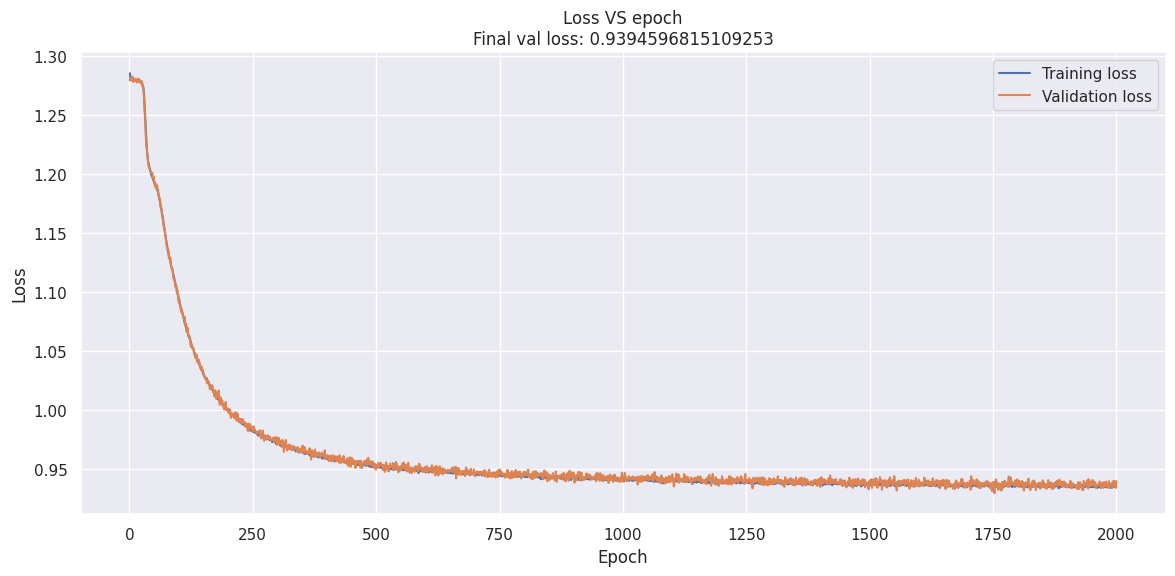

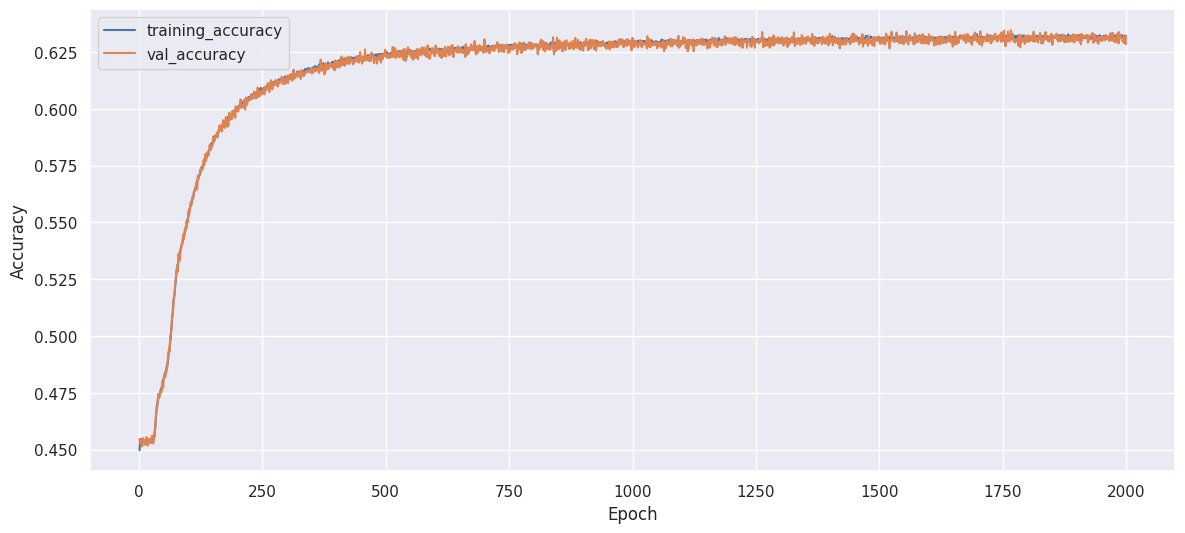

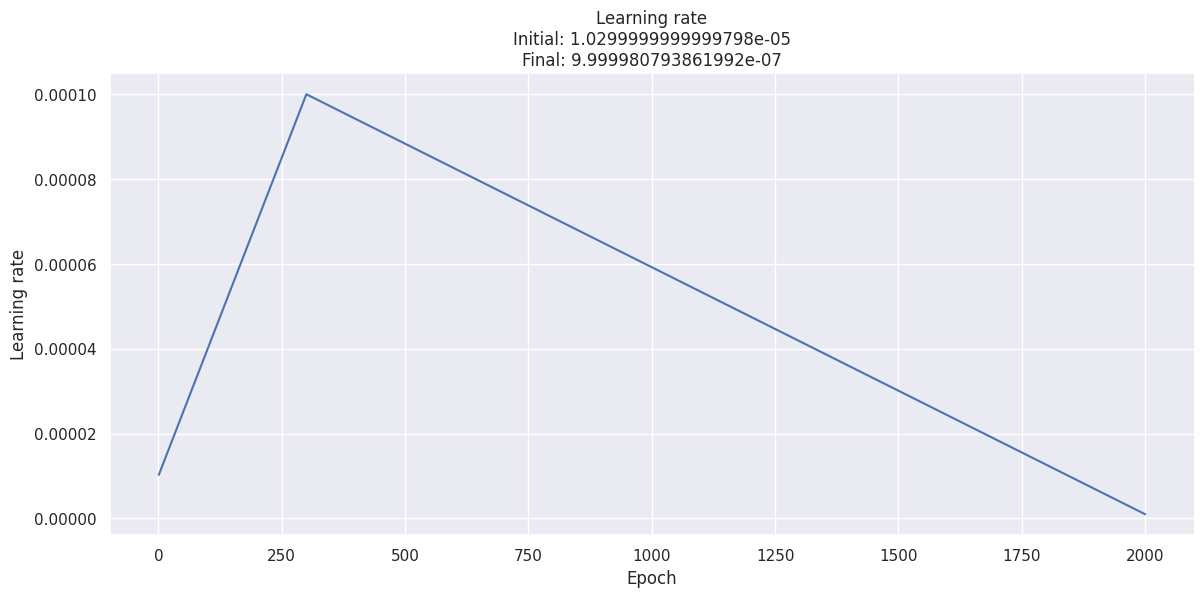

In [4]:
checkpoint_epochs = sorted([
    int(f.split('_')[-1].split('.')[0])
    for f in os.listdir(MODEL_DIR)
    if '.pt' in f
])

selected_checkpoint_epoch = checkpoint_epochs[-1]

checkpoint_id = [f for f in os.listdir(MODEL_DIR) if f'{selected_checkpoint_epoch}.pt' in f][0]

logger.info(f'Selected checkpoint: {checkpoint_id}')

pretrained_model, _, training_history = load_checkpoint(
    MODEL_DIR,
    checkpoint_id,
    device=device
)

plot_training_history(training_history)

Replace the pretrained model's head with a new classification head.

In [5]:
classification_model = replace_decoder_with_classification_head(
    pretrained_model,
    n_classes=q,
    device=device,
    embedding_agg='flatten',
    head_hidden_dim=[128, 64, 32],
    head_activation='relu',
    head_output_activation='identity',
    head_batch_normalization=True,
    head_dropout_p=0.2
)

freeze_encoder_weights(classification_model, trainable_modules=['decoder'])

2024-05-24 14:30:59,582 - fine_tuning_root_inference - INFO - Module: input_embedding| N parameters: 640 | Parameters trainable: False | Training mode: False
2024-05-24 14:30:59,583 - fine_tuning_root_inference - INFO - Module: positional_embedding| N parameters: 0 | Parameters trainable: True | Training mode: False
2024-05-24 14:30:59,583 - fine_tuning_root_inference - INFO - Module: encoder_layer| N parameters: 132480 | Parameters trainable: False | Training mode: False
2024-05-24 14:30:59,584 - fine_tuning_root_inference - INFO - Module: transformer_encoder| N parameters: 264960 | Parameters trainable: False | Training mode: False
2024-05-24 14:30:59,584 - fine_tuning_root_inference - INFO - Module: embedding_agg_layer| N parameters: 0 | Parameters trainable: True | Training mode: False
2024-05-24 14:30:59,585 - fine_tuning_root_inference - INFO - Module: decoder| N parameters: 4270884 | Parameters trainable: True | Training mode: True


In [6]:
classification_model

TransformerClassifier(
  (input_embedding): Embedding(5, 128)
  (positional_embedding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=256, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=T

Checks.

In [7]:
batch_size = 32

# Shape: (batch_size, q).
pred = classification_model(leaves_train[:batch_size]).detach()

print(pred.shape)

compute_accuracy(pred, roots_train[:batch_size])

torch.Size([32, 4])


tensor(0.2500, device='cuda:0')

Training.

In [8]:
fine_tuning_training_history = {
    'training_loss': [],
    'val_loss': [],
    'training_accuracy': [],
    'val_accuracy': [],
    'learning_rate': []
}

2024-05-24 14:31:17,660 - fine_tuning_root_inference - INFO - Training model
2024-05-24 14:31:23,239 - fine_tuning_root_inference - INFO - Initial training loss: 1.500872015953064 | Initial training accuracy: 0.24943749606609344 | Initial val loss: 1.4934570789337158 | Initial val accuracy: 0.2605000138282776
100%|█| 25/25 [03:02<00:00,  7.28s/it, learning_rate=0.0001, training_accuracy=tensor(0.8103), training_loss=tensor(0.5513), val_accuracy=tensor(0.3085, device='cuda:0'), val_loss=tensor(2.4628, device='cuda:
2024-05-24 14:34:25,341 - fine_tuning_root_inference - INFO - Last epoch: 25


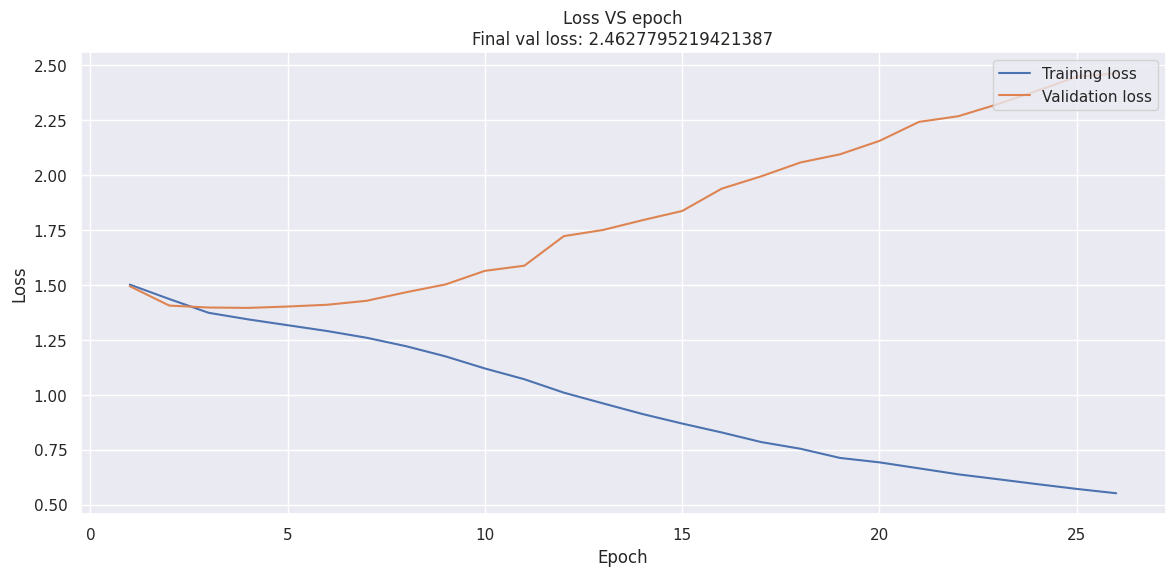

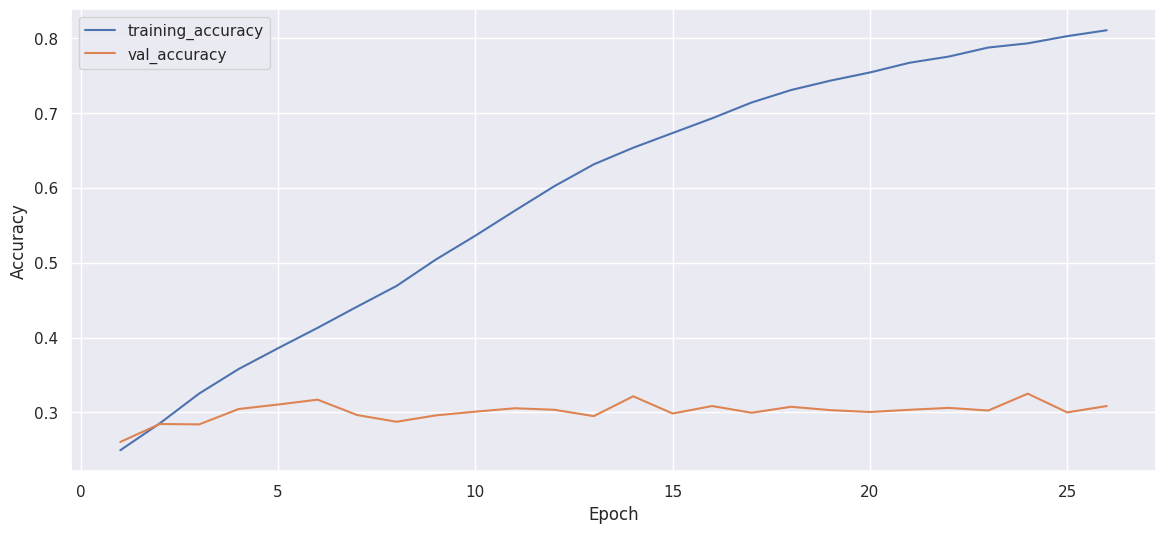

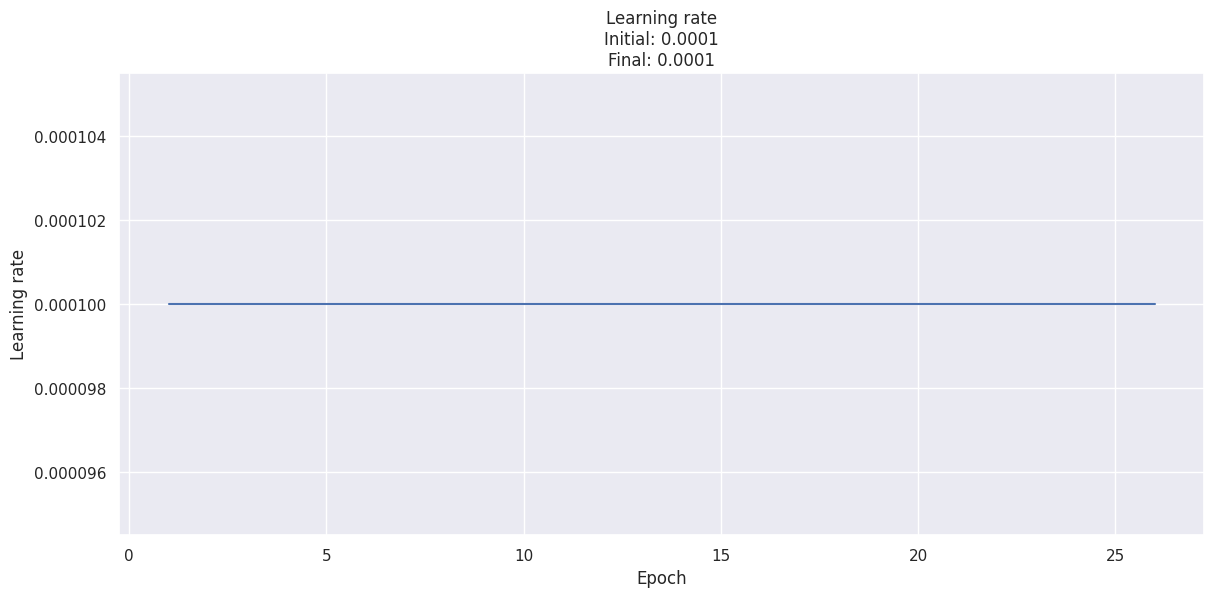

In [9]:
n_epochs = 25

loss_fn = torch.nn.CrossEntropyLoss()

_, fine_tuning_training_history = train_model(
    model=classification_model,
    training_data=(leaves_train, roots_train),
    test_data=(leaves_test, roots_test),
    n_epochs=n_epochs,
    loss_fn=loss_fn,
    learning_rate=1e-4,
    batch_size=32,
    early_stopper=None,
    training_history=fine_tuning_training_history
)

plot_training_history(fine_tuning_training_history)

In [18]:
len(fine_tuning_training_history['learning_rate'])

26

In [22]:
len(range(0, len(fine_tuning_training_history['learning_rate'])))

26

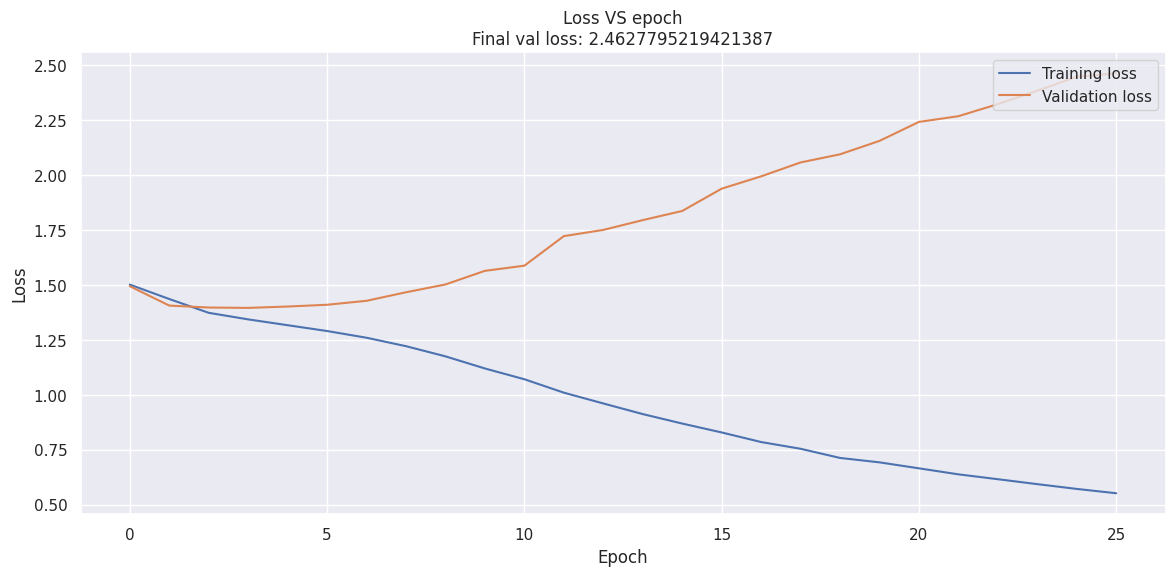

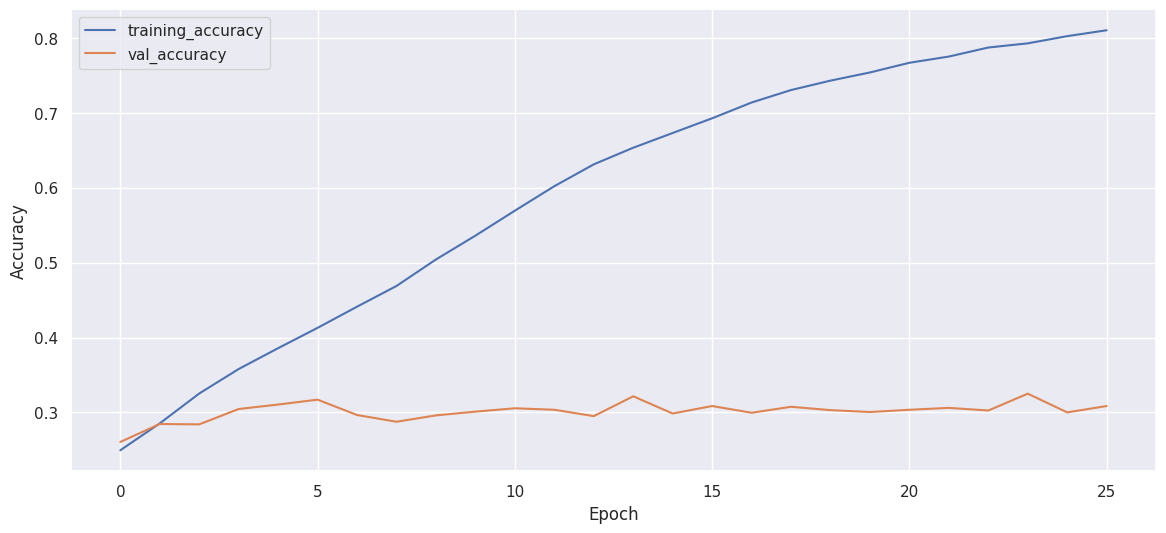

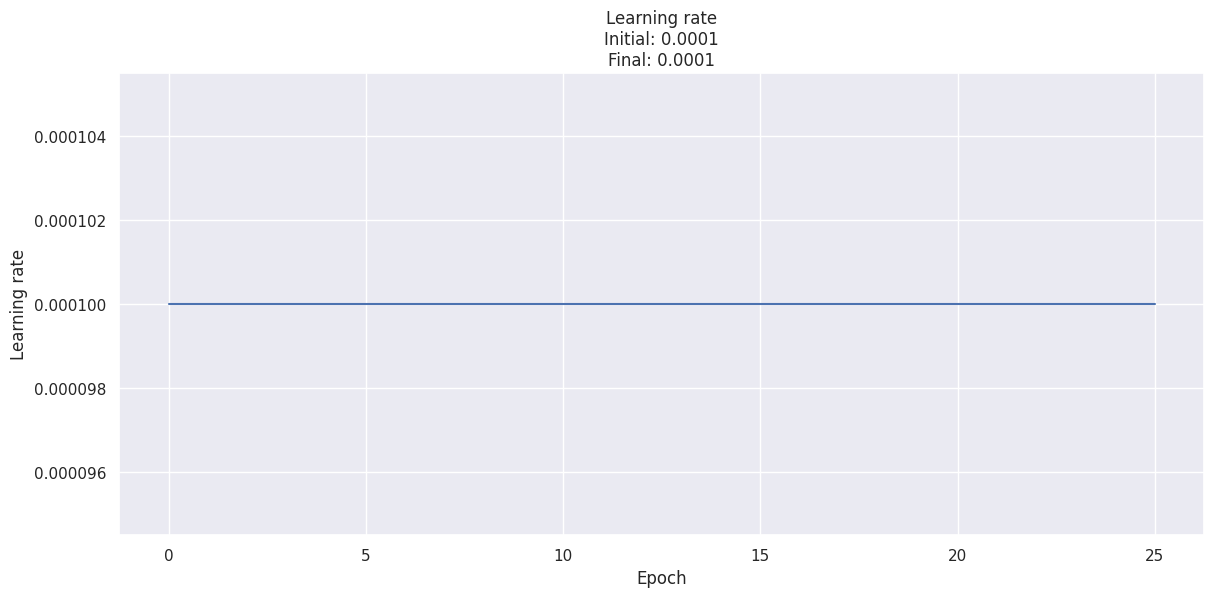

In [23]:
plot_training_history(fine_tuning_training_history)

Hypotheses:
- Pre-training with MLM does not help in our case.
- We got some of the hyperparameters wrong.
- Use a `<cls>` token?
- Wrong data regime --> Not enough training data?